In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
 
class Network:
    rate = 0.1     # 学習率
    decay = 0.1    # 学習率減衰
    per = 50       # 何エポックごとに学習率を減衰させるか
 
    epsilon = 1.0  # シグモイド関数の傾き
 
    def __init__(self, *args):
        self.layers = list(args)  # 各層のニューロン数
        self.weights = ([])       # 各層間の重みベクトル
        self.patterns = ([])      # 入力パターンベクトル
        self.labels = ([])        # 教師ニューロンインデックス
        self.outputs = ([])       # 各ニューロンの出力値ベクトル
 
    def init_weights(self, a=0.0, b=1.0):
        for i in range(len(self.layers)):
            if i + 1 >= len(self.layers):
                break
            self.weights.append((b - a) * np.random.rand(self.layers[i + 1], self.layers[i]) + a)
 
    def load_iris(self):
        data = open('iris.data', 'r')
        lines = data.read().split()
        dataset = ([])
 
        for line in lines:
            pattern = line.split(',')
            dataset.append(pattern)
        data.close()
 
        for pattern in dataset:
            self.patterns.append(list(map(float, pattern[0:-1])))
            # setosaは0番目ニューロン、versicolorは1番目ニューロン、virginicaは2番目ニューロンが担当する
            if pattern[-1] == 'Iris-setosa':
                self.labels.append(0)
            elif pattern[-1] == 'Iris-versicolor':
                self.labels.append(1)
            else:
                self.labels.append(2)
 
    @staticmethod
    def input_sum(inputs, weights):
        return np.dot(inputs, weights)
 
    def output(self, inputs, weights):
        return self.sigmoid(self.input_sum(inputs, weights))
 
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-self.epsilon * x))
 
    def forward(self, pattern):
        self.outputs.clear()  # まず出力値情報をクリア
 
        out = ([])  # 前層ニューロンの出力ベクトル
        self.outputs.append(pattern)  # まず入力層ニューロンの出力(入力パターン)を追加
 
        for layer in range(len(self.layers)):
            out = ([])
            if layer == 1:  # 第１中間層ならば入力パターンが前層ニューロンの出力となる
                for n in range(self.layers[layer]):
                    out.append(self.output(pattern, self.weights[layer-1][n]))
 
                self.outputs.append(out)  # 出力値を追加
 
            elif layer > 1:  # 第１中間層以降の層では前層の出力を使う
                for n in range(self.layers[layer]):
                    out.append(self.output(self.outputs[-1], self.weights[layer-1][n]))
 
                self.outputs.append(out)  # 出力値を追加
 
        return out
 
    def backward(self, pattern):
        deltas = self.calc_delta(pattern)  # δを計算
        for l in reversed(range(1, len(self.layers))):  # ネットワークを逆順処理していく
            for j, jj in enumerate(self.outputs[l]):
                for i, ii in enumerate(self.outputs[l-1]):
                    self.weights[l-1][j][i] += self.rate * deltas[l-1][j] * ii  # 重みを更新
 
    def calc_delta(self, pattern):
        teacher = ([0.1, 0.1, 0.1])  # 教師ニューロンを作成
        teacher[self.labels[pattern]] = 0.9  # ラベルに該当する教師ニューロンの出力を0.9に
        deltas = ([])  # 全ニューロンのδ
 
        for l in reversed(range(1, len(self.layers))):  # ネットワークを逆順処理していく
            tmp_delta = ([])
            for j in range(self.layers[l]):
                if l == len(self.layers) - 1:  # 最終層ならば
 
                    delta = self.epsilon * \
                            (teacher[j] - self.outputs[l][j]) * \
                            self.outputs[l][j] * (1 - self.outputs[l][j])
 
                    tmp_delta.append(delta)
 
                else:  # 最終層以外
                    t_weights = np.array(self.weights[l]).T
                    delta = self.epsilon * \
                            self.outputs[l][j] * (1 - self.outputs[l][j]) * \
                            np.dot(deltas[-1], t_weights[j])
 
                    tmp_delta.append(delta)
 
            deltas.append(tmp_delta)
 
        return deltas[::-1]  # δは逆順で返す
 
    def train(self, epoch):
        """
        訓練関数
        :param epoch:
        :return:
        """
        errors = ([])
        for e in range(epoch):  # 最大学習回数で回す
            error = 100 - self.test()
            for p, pat in enumerate(self.patterns):  # 入力パターンごとに回す
 
                self.forward(pat)  # 順伝播処理で出力値を計算
 
                self.backward(p)  # 逆伝播で重みを更新
 
            print(str(e+1) + ' / ' + str(epoch) + ' epoch.' + ' [ error: ' + str(error) + ' ]')
 
            if (e+1) % self.per == 0:  # 学習率減衰
                self.rate *= self.decay
 
            errors.append(error)  # 不正解率
 
        #  不正解立を描画
        plt.xlabel('epochs')
        plt.ylabel('error (%)')
        plt.plot(errors)
        plt.savefig('error.png', dpi=300)
 
    def test(self):
        """
        テスト関数
        :return: accuracy (%)
        """
        correct = 0
        for p in range(len(self.patterns)):
            self.forward(self.patterns[p])
            max = 0
            ans = -1
            # 一番出力値の高いニューロンを取ってくる
            for o, out in enumerate(self.outputs[len(self.layers)-1]):
                if max < out:
                    max = out
                    ans = o
            # もしそのニューロンの番号とラベルの番号があっていれば正解！
            if ans == self.labels[p]:
                correct += 1
 
        accuracy = correct / len(self.patterns) * 100
        return accuracy

In [2]:
net = Network(4, 20, 3)
net.init_weights(-1.0, 1.0)

In [3]:
net.load_iris()

1 / 300 epoch. [ error: 66.66666666666667 ]
2 / 300 epoch. [ error: 66.66666666666667 ]
3 / 300 epoch. [ error: 66.66666666666667 ]
4 / 300 epoch. [ error: 66.66666666666667 ]
5 / 300 epoch. [ error: 63.333333333333336 ]
6 / 300 epoch. [ error: 36.0 ]
7 / 300 epoch. [ error: 33.33333333333334 ]
8 / 300 epoch. [ error: 33.33333333333334 ]
9 / 300 epoch. [ error: 33.33333333333334 ]
10 / 300 epoch. [ error: 33.33333333333334 ]
11 / 300 epoch. [ error: 33.33333333333334 ]
12 / 300 epoch. [ error: 33.33333333333334 ]
13 / 300 epoch. [ error: 33.33333333333334 ]
14 / 300 epoch. [ error: 33.33333333333334 ]
15 / 300 epoch. [ error: 33.33333333333334 ]
16 / 300 epoch. [ error: 33.33333333333334 ]
17 / 300 epoch. [ error: 33.33333333333334 ]
18 / 300 epoch. [ error: 33.33333333333334 ]
19 / 300 epoch. [ error: 33.33333333333334 ]
20 / 300 epoch. [ error: 33.33333333333334 ]
21 / 300 epoch. [ error: 33.33333333333334 ]
22 / 300 epoch. [ error: 33.33333333333334 ]
23 / 300 epoch. [ error: 33.333

201 / 300 epoch. [ error: 2.666666666666657 ]
202 / 300 epoch. [ error: 2.666666666666657 ]
203 / 300 epoch. [ error: 2.666666666666657 ]
204 / 300 epoch. [ error: 2.666666666666657 ]
205 / 300 epoch. [ error: 2.666666666666657 ]
206 / 300 epoch. [ error: 2.666666666666657 ]
207 / 300 epoch. [ error: 2.666666666666657 ]
208 / 300 epoch. [ error: 2.666666666666657 ]
209 / 300 epoch. [ error: 2.666666666666657 ]
210 / 300 epoch. [ error: 2.666666666666657 ]
211 / 300 epoch. [ error: 2.666666666666657 ]
212 / 300 epoch. [ error: 2.666666666666657 ]
213 / 300 epoch. [ error: 2.666666666666657 ]
214 / 300 epoch. [ error: 2.666666666666657 ]
215 / 300 epoch. [ error: 2.666666666666657 ]
216 / 300 epoch. [ error: 2.666666666666657 ]
217 / 300 epoch. [ error: 2.666666666666657 ]
218 / 300 epoch. [ error: 2.666666666666657 ]
219 / 300 epoch. [ error: 2.666666666666657 ]
220 / 300 epoch. [ error: 2.666666666666657 ]
221 / 300 epoch. [ error: 2.666666666666657 ]
222 / 300 epoch. [ error: 2.666666

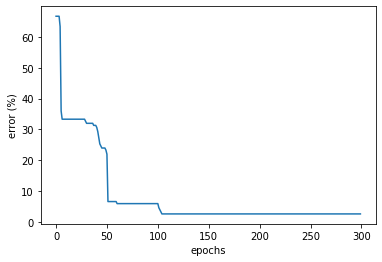

In [4]:
net.train(300)

In [5]:
acc = net.test()
print('Accuracy: ' + str(acc) + '%')

Accuracy: 97.33333333333334%
